# Demo notebook BrightEyes_ISM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sgn
from numpy.random import poisson

import brighteyes_ism.analysis.APR_lib as apr
import brighteyes_ism.analysis.Deconv_lib as deconv
import brighteyes_ism.analysis.FRC_lib as frc
import brighteyes_ism.analysis.FocusISM_lib as fism

import brighteyes_ism.simulation.PSF_sim as ism
import brighteyes_ism.simulation.Tubulin_sim as simTub

## Point-spread functions

### Simulation settings and SPAD array parameters

In [4]:
N = 5 # number of detector elements in each dimension
Nx = 201 # number of pixels of the simulation space
pxsizex = 25 # pixel size of the simulation space (nm)
pxdim = 50e3 # detector element size in real space (nm)
pxpitch = 75e3 # detector element pitch in real space (nm)
M = 500 # total magnification of the optical system (e.g. 100x objective follewd by 5x telescope)

#%% PSF simulation 2D

exPar = ism.simSettings()
exPar.wl = 640 # excitation wavelength (nm)
exPar.mask_sampl = 31

emPar = exPar.copy()
emPar.wl = 660 # emission wavelength (nm)

z_shift = 0 #nm

### Generate excitation PSF and detection PSFs

In [5]:
PSF, detPSF, exPSF = ism.SPAD_PSF_2D(N, Nx, pxpitch, pxdim, pxsizex, M, exPar, emPar, z_shift=z_shift)

PSF /= np.max(PSF)

Calculating field near the focus:


XY plane: 100%|██████████████████████████████████████████████████████████████████████| 201/201 [00:08<00:00, 23.54it/s]


Calculating field near the focus:


XY plane: 100%|██████████████████████████████████████████████████████████████████████| 201/201 [00:08<00:00, 25.04it/s]


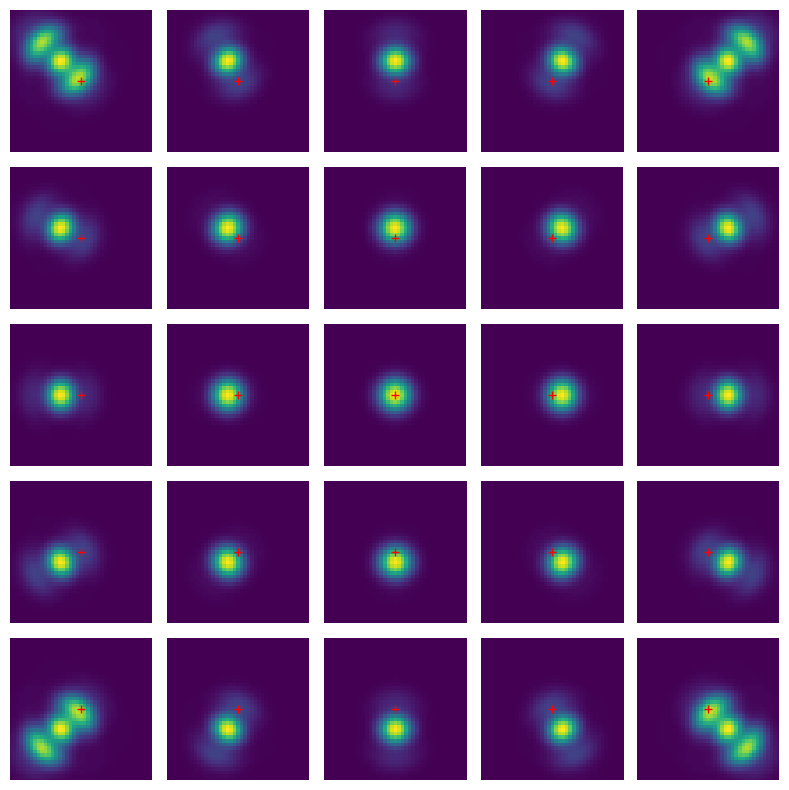

In [6]:
fig = plt.figure(figsize=(8,8))
for i in range(N*N):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(PSF[:,:,i], extent = [-(Nx//2*pxsizex), Nx//2*pxsizex, -(Nx//2*pxsizex), Nx//2*pxsizex])
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)
    ax.plot(0,0,'+r')
    plt.axis('off')

plt.tight_layout()

(-0.5, 4.5, 4.5, -0.5)

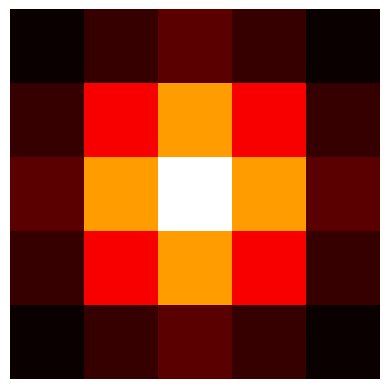

In [7]:
fingerprint = ism.Fingerprint(PSF)
plt.figure();
plt.imshow(fingerprint, cmap='hot')
plt.axis('off')

### Find shift vectors

Text(0, 0.5, 'Shift$_y$ (nm)')

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


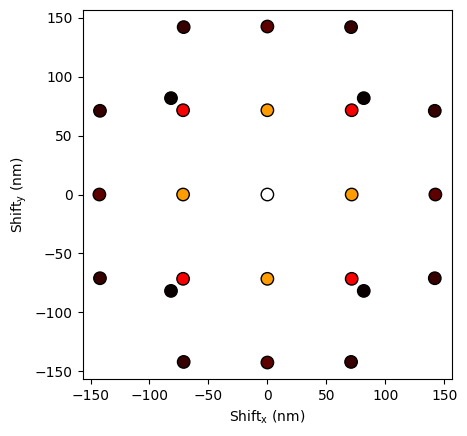

In [8]:
shift = apr.ShiftVectors(PSF, 100, 12)[0]
shift *= pxsizex

plt.figure()
plt.scatter(shift[:,0], shift[:,1], s = 80, c = fingerprint, edgecolors = 'black', cmap = 'hot')
plt.gca().set_aspect('equal', 'box')

plt.xlabel(r'Shift$_x$ (nm)')
plt.ylabel(r'Shift$_y$ (nm)')

## Tubulin

### Simulate ground truth

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:00<00:00,  8.04it/s]

tubulin filament out of the boundaries [201.22677633] [50.18805892] 201
tubulin filament out of the boundaries [201.53628118] [68.71106562] 201


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.75it/s]


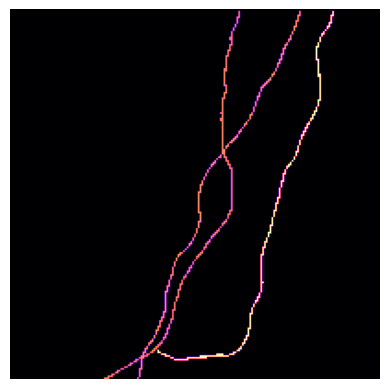

In [10]:
#%% Generate tubulin

tubulin = simTub.tubSettings()
tubulin.xy_pixel_size = pxsizex
tubulin.xy_dimension = Nx
tubulin.xz_dimension = 1     
tubulin.z_pixel = 1     
tubulin.n_filament = 3
tubulin.radius_filament = pxsizex*0.6
tubulin.intensity_filament = [0.5,0.9]  
phTub = simTub.functionPhTub(tubulin)
plt.figure()
plt.imshow(phTub[:,:,0],cmap='magma')
plt.axis('off')

TubDec = phTub[:,:,0]

### Simulate detected images

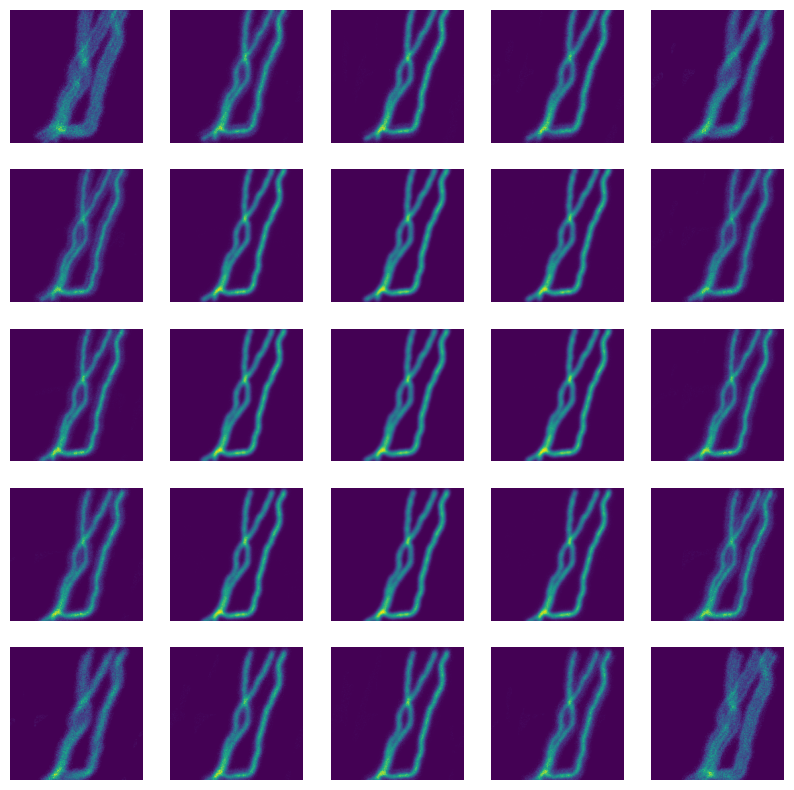

In [11]:
#%% Convolve tubulin with psf

img = np.empty(PSF.shape)

for n in range(N**2):
    img[:, :, n] = sgn.convolve(TubDec, PSF[:, :, n] ,mode = 'same')

#%% Convert to photons and add Poisson noise

img *= 1e2
img = np.uint16(img)

img_1 = poisson(img)
img_2 = poisson(img)

fig = plt.figure(figsize=(10,10))
for i in range(N*N):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img_1[:,:,i])
    plt.axis('off')

### Compare confocal and ISM

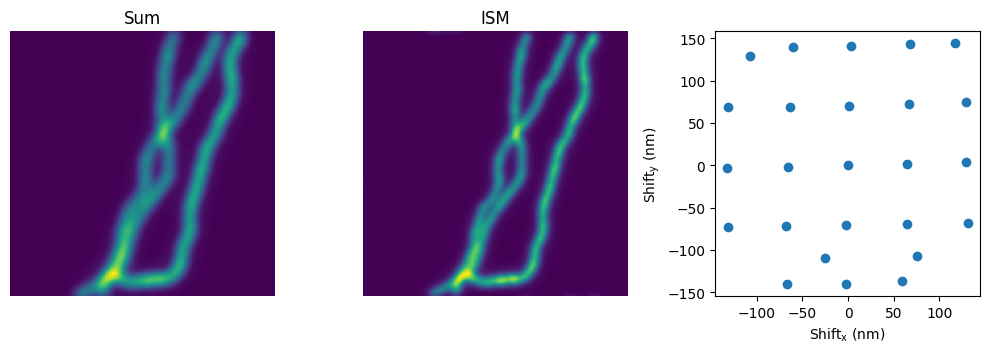

In [12]:
img_sum_1 = np.sum(img_1, axis = -1)
img_sum_2 = np.sum(img_2, axis = -1)

usf = 100
ref = N**2//2

shift_1, img_ism_1 = apr.APR(img_1, usf, ref, pxsize = pxsizex)
shift_2, img_ism_2 = apr.APR(img_2, usf, ref, pxsize = pxsizex)

img_ism_sum_1 = np.sum(img_ism_1, axis=-1)
img_ism_sum_2 = np.sum(img_ism_2, axis=-1)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_sum_1)
ax.set_title('Sum')
plt.axis('off')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_ism_sum_1)
ax.set_title('ISM')
plt.axis('off')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(shift_1[:,0], shift_1[:,1])
ax.set_aspect(1./ax.get_data_ratio(), 'box')
ax.set_xlabel(r'Shift$_x$ (nm)')
ax.set_ylabel(r'Shift$_y$ (nm)')

plt.tight_layout()

### Multi-image deconvolution

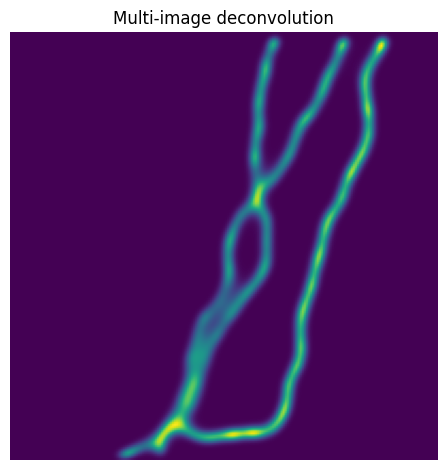

In [13]:
img_deconv = deconv.MultiImg_RL_FFT( PSF, img_1, max_iter = 10)

plt.figure()
plt.imshow(img_deconv)
plt.title('Multi-image deconvolution')
plt.axis('off')

plt.tight_layout()

### Calculate resolution based on FRC analysis

Text(0.5, 1.0, 'ISM - Resolution = 143.05 nm')

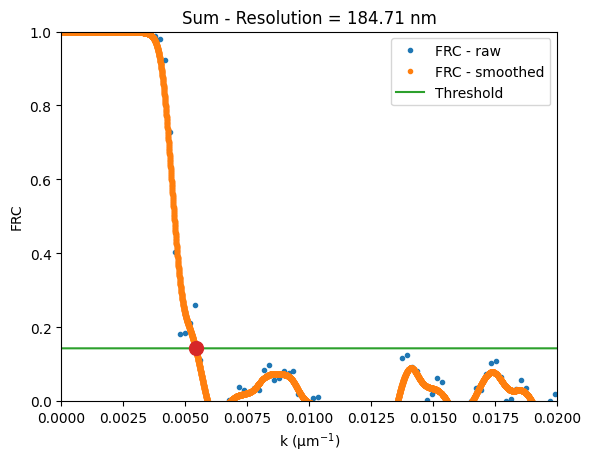

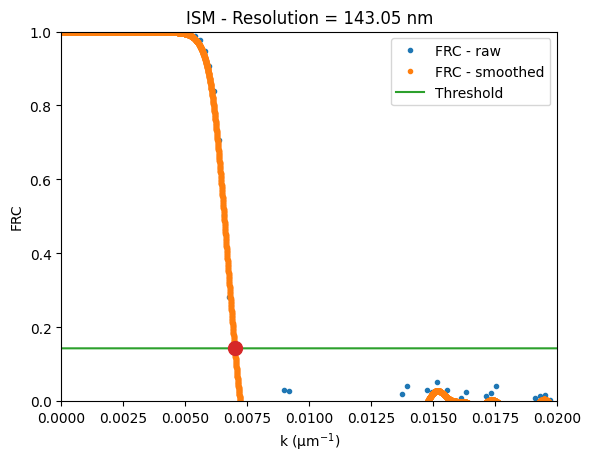

In [14]:

frc_sum = frc.FRC_resolution(img_sum_1, img_sum_2, px=pxsizex)

frc_ism = frc.FRC_resolution(img_ism_sum_1, img_ism_sum_2, px=pxsizex)


frc.plotFRC(*frc_sum)
plt.title(f'Sum - Resolution = {frc_sum[0]:.2f} nm')

frc.plotFRC(*frc_ism)
plt.title(f'ISM - Resolution = {frc_ism[0]:.2f} nm')


### Generate out-of-focus PSFs

Calculating field near the focus:


XY plane: 100%|██████████████████████████████████████████████████████████████████████| 201/201 [00:07<00:00, 26.08it/s]


Calculating field near the focus:


XY plane: 100%|██████████████████████████████████████████████████████████████████████| 201/201 [00:07<00:00, 26.33it/s]


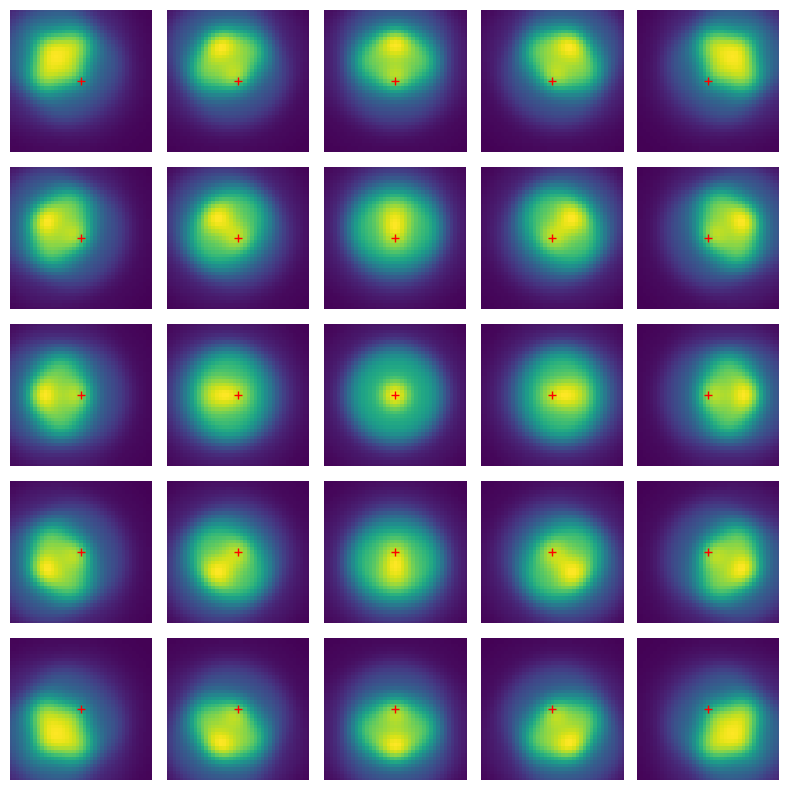

In [15]:
Dof = emPar.wl * emPar.n / emPar.na**2 # depth-of-field, nm

z_shift = Dof #nm

PSF_oof, detPSF_oof, exPSF_oof = ism.SPAD_PSF_2D(N, Nx, pxpitch, pxdim, pxsizex, M, exPar, emPar, z_shift=z_shift)

PSF_oof /= np.max(PSF_oof)

fig = plt.figure(figsize=(8,8))
for i in range(N*N):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(PSF_oof[:,:,i], extent = [-(Nx//2*pxsizex), Nx//2*pxsizex, -(Nx//2*pxsizex), Nx//2*pxsizex])
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)
    ax.plot(0,0,'+r')
    plt.axis('off')

plt.tight_layout()

### Calculate photons from out-of-focus tubulin

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.52it/s]

tubulin filament out of the boundaries [201.14838902] [117.00868625] 201
tubulin filament out of the boundaries [9.40776435] [201.13202294] 201


(-0.5, 200.5, 200.5, -0.5)

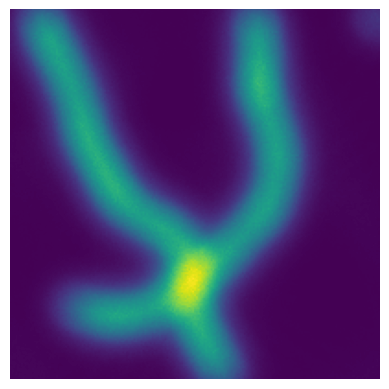

In [16]:
#%% Generate tubulin

tubulin = simTub.tubSettings()
tubulin.xy_pixel_size = pxsizex
tubulin.xy_dimension = Nx
tubulin.xz_dimension = 1     
tubulin.z_pixel = 1     
tubulin.n_filament = 3
tubulin.radius_filament = pxsizex*0.6
tubulin.intensity_filament = [0.5,0.9]  
phTub = simTub.functionPhTub(tubulin)

TubDec = phTub[:,:,0]

#%% Convolve tubulin with psf

img_oof = np.empty(PSF.shape)

for n in range(N**2):
    img_oof[:, :, n] = sgn.convolve(TubDec, PSF_oof[:, :, n] ,mode = 'same')

#%% Convert to photons and add Poisson noise

img_oof *= 10
img_oof = np.uint16(img_oof)

img_oof = poisson(img_oof)

# show it

img_oof_sum = np.sum(img_oof, axis = -1)

plt.figure()
plt.imshow(img_oof_sum)
plt.axis('off')


### Sum in-focus and out-of-focus light

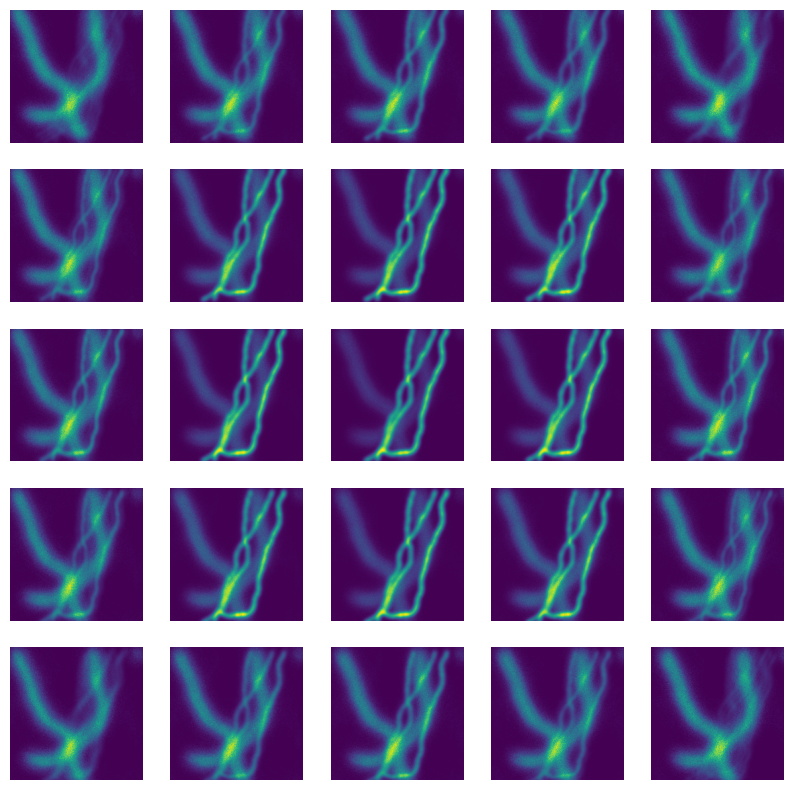

In [17]:
#%% Add oof tubulin

img_bkg = img + img_oof

#%% Show total image

fig = plt.figure(figsize=(10,10))
for i in range(N*N):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img_bkg[:,:,i])
    plt.axis('off')

### Apply focus-ISM

In [18]:
img_bkg_sum = np.sum(img_bkg, axis = -1)

Focus_sum, Bkg_sum, ism_sum = fism.focusISM(img_bkg, calibration = PSF)

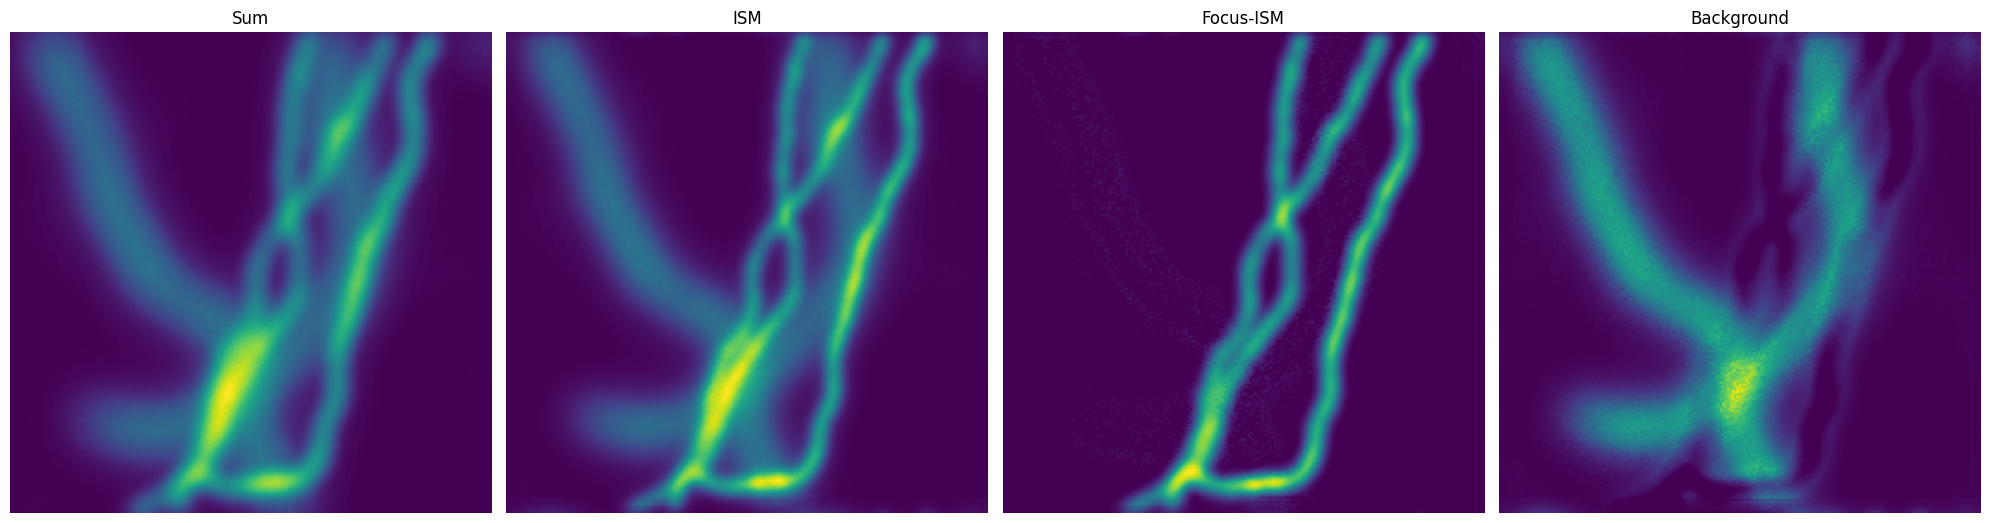

In [19]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_bkg_sum)
ax.set_title('Sum')
plt.axis('off')

ax = fig.add_subplot(1, 4, 2)
ax.imshow(ism_sum)
ax.set_title('ISM')
plt.axis('off')

ax = fig.add_subplot(1, 4, 3)
ax.imshow(Focus_sum)
ax.set_title('Focus-ISM')
plt.axis('off')


ax = fig.add_subplot(1, 4, 4)
ax.imshow(Bkg_sum)
ax.set_title('Background')
plt.axis('off')

plt.tight_layout()